# ARIMA
Autoregression Integration Moving Average  

Different from previous MA, this isn't computing moving average.  Taking a time series and positing that it is the MA of another time series.  
Use that idea as a way of predicting what's going to happen with our time series.  

AR = autoregression  
I = Integration aka differences
MA = Moving average which is new, deals with temporary shocks in data  

## 7.2 - MA Models

## 7.3 - MA Simulation

**Simulating our tunnel**
Only have access to how many cars are in the tunnel.  This is typical.  If have an MA model really the idea is my moving average is something but don't know what.  Don't have access to tho original entering th etunnel data.  Only have access to what's in th etunnel so got a *second-order thing*

Know what's in the tunnel, can see what's in the tunnel, use that info for predicting - assumption of a MA



In [18]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import math
import matplotlib.pyplot as plt


plt.rcParams['figure.dpi'] = 150


def rmse(predicted, actual):
    # print(predicted)
    # print(actual)
    diffs = predicted - actual
    return math.sqrt(np.mean(diffs ** 2))

# simulator has 500 minutes, each have cars from 0 - 5
tunnel_df = pd.DataFrame(np.random.randint(5, size=500), columns=["Entering"])
tunnel_df.head()

,Entering
0,1
1,2
2,3
3,4
4,4


In [19]:
# predictor column coming from the entering column
# sum of the last 3 entering

tunnel_df['In Tunnel'] = tunnel_df['Entering'].rolling(3).sum()[2:]
tunnel_df.head(7)

,Entering,In Tunnel
0,1,NaN
1,2,NaN
2,3,6.0
3,4,9.0
4,4,11.0
5,0,8.0
6,2,6.0


<AxesSubplot:>

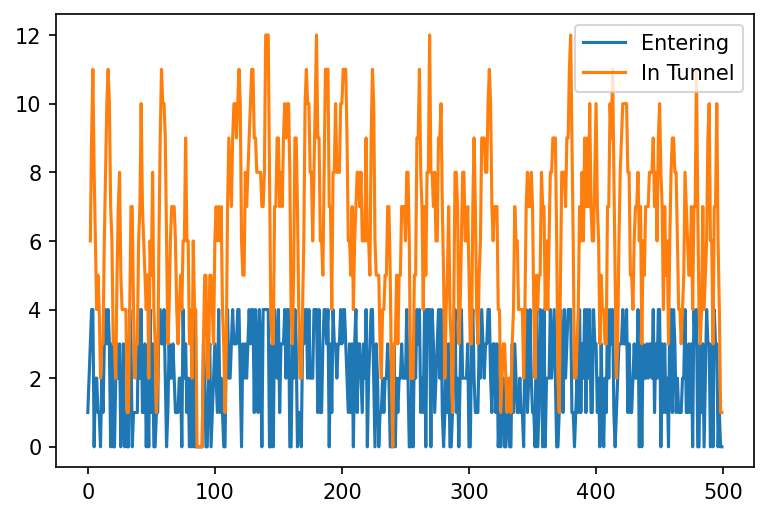

In [20]:
tunnel_df.plot()


In [21]:
ma2_model = sm.tsa.arima.ARIMA(tunnel_df['In Tunnel'], order = (0,0,2), trend = 'n').fit()
print(ma2_model.param_names)

c:\Users\hugho\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


['ma.L1', 'ma.L2', 'sigma2']


<AxesSubplot:>

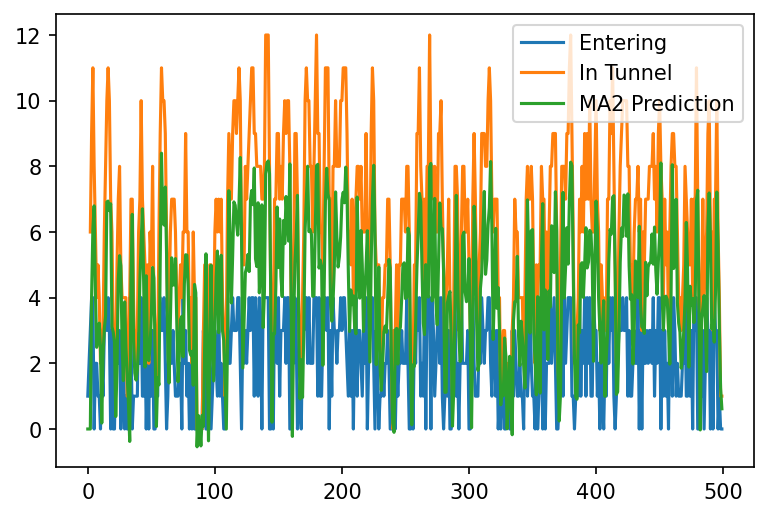

In [22]:
tunnel_df['MA2 Prediction'] = ma2_model.predict()
tunnel_df.plot()

Compare the models: AR(2) and MA(2)

<AxesSubplot:>

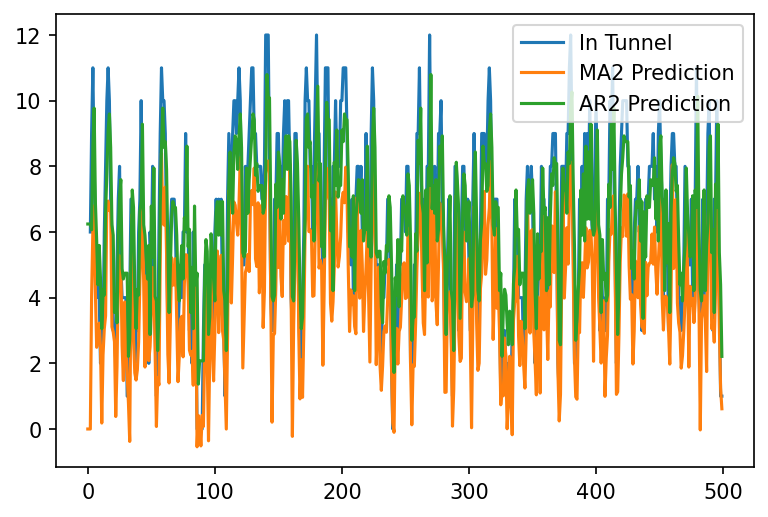

In [23]:
ar2_model = sm.tsa.arima.ARIMA(tunnel_df['In Tunnel'], order = (2,0,0)).fit()

tunnel_df['AR2 Prediction'] = ar2_model.predict()

tunnel_preds = tunnel_df.drop(columns =['Entering'])
tunnel_preds.plot()

Now we will throw in an AR(12) and an ARMA(2,2)

In [24]:
ar12_model = sm.tsa.arima.ARIMA(tunnel_df['In Tunnel'], order = (12,0,0), trend = 'n').fit()
ar2ma2_model = sm.tsa.arima.ARIMA(tunnel_df['In Tunnel'], order = (2,0,2), trend = 'n').fit()
print("MA2", rmse(tunnel_df['MA2 Prediction'], tunnel_df['In Tunnel']))
print("AR2", rmse( tunnel_df['AR2 Prediction'], tunnel_df['In Tunnel']))
print("AR12", rmse(ar12_model.predict(), tunnel_df['In Tunnel']))
print("AR2MA2", rmse(ar2ma2_model.predict(), tunnel_df['In Tunnel']))

MA2 2.5372732737267096
AR2 1.8115925927596932
AR12 1.517206260102784
AR2MA2 1.5989246954272605


In [25]:
print("MA2", rmse(tunnel_df['MA2 Prediction'], tunnel_df['In Tunnel']))

MA2 2.5372732737267096


What do we mean by a "Large AR" for example above AR12?  
When have a Large AR it does almost as well as the MA2.  
If have an infinite AR it actually includes the MA because the MAs are differences of ARs  
A large AR should behave as well as the MA model.  


## 7.6 ARMA(p,q) with GD

In the context of ARIMA, can think of the MA as a time series that is the MA of something else, specificalrly the MA of the errors

Now we're going to learn at least the MA coefficients,by gradient descent. Remember, the way we get the AR coefficientsis we just use a linear regression, that doesn't work for the MA coefficients so we need another way of getting the MA coefficients. 1What we're doing here is we're using gradient descent.


In [26]:
import pandas as pd
import math
import numpy as np
jobs_df = pd.read_csv('./data/UK_job_vacancies.csv')
jobs_df.head()

,Month,Vacancies
0,2001 MAY,567.0
1,2001 JUN,563.0
2,2001 JUL,553.0
3,2001 AUG,552.0
4,2001 SEP,535.0


In [27]:
# Our RMSE and AR code
def rmse(predicted, actual):
    diffs = predicted - actual
    return math.sqrt(np.mean(diffs ** 2))

def train_ar(values, order):
    target_vector = np.array(values[order:])
    lagged_values = []
    for i in range(len(values) - order):
        lagged_values.append(values[i:i+order])
    design_matrix = np.array(lagged_values)
    return np.linalg.inv(design_matrix.transpose() @ design_matrix) @ design_matrix.transpose() @ target_vector

In [28]:
# Now we will do the AR coefficients.
# Give the data in question the name series and ae will compute anAR(3) model
series = jobs_df['Vacancies']
ar_deg = 3
ar_coef = train_ar(series, ar_deg)
print(ar_coef)

[ 0.34228651 -1.34176882  2.00015731]


In [29]:
#First step: set the initial value of the coefficients to be 0 and set up the learning rate
ma_deg = 2
ma_coef = np.zeros(ma_deg)
learning_rate = 0.0001

We will put in what will be an outer loop. Going through series will be an inner loop. In each iteration of the outer loop we do a gradient descent step with the gradient we have computed in the inner loop. In each iteration of the outer loop we compute new MA coefficients and a new rmse, which we hope is decreasing. We will loop only 5 times for now but will run it with a higher number later. So the shape of the code is as follows:

``` 
    for x in range(5):
        Compute new MA coefficients
        print("Step", x, rmse(predicted, series))
        print(ma_coef)
```

In [30]:
def grad_descent_ma(series, ma_deg, ar_deg, ar_coef, ma_coef):
    for x in range(100):
        #init beginning of outter loop
        ma_grad_total = np.zeros(ma_deg)
        last_errors = [0] * ma_deg
        predicted = [math.nan] * ar_deg

        # inner loop
        # start after the first ar_deg rows (because we cannot do anything with them)
        # Subtraction - note that when i is 0 we will already be beyond the first ar_deg rows.
        for i in range (len(series) - ar_deg):
            # predictions using the coeffs we have
            # Note: MA ones 0 when start but get filled in by loop
            ar_pred = np.dot(ar_coef, series[i:i+ar_deg])
            ma_pred = np.dot(ma_coef, last_errors)
            
            # total pred
            pred = ar_pred + ma_pred
            predicted.append(pred)

            # when we're at i - look ahead to i + ar_deg
            observed = series[i+ar_deg]

            # calc error
            error = (observed - pred)

            #array of errors for the pred gradient
            ma_pred_grad = np.array(last_errors)

            # gets new error and loses old one
            last_errors = last_errors[1:] + [error]

            #
            ma_grad_total = ma_grad_total - 2 * (ma_pred_grad * (observed - pred))
        
        # ma_grad = average of the ones we've seen
        ma_grad = ma_grad_total/ (len(series) - ar_deg)
        # use it in comp of the ma_coef
        ma_coef = ma_coef - ma_grad * learning_rate

        if (x % 10) == 0:
            print("Step", x, rmse(predicted, series), ma_coef)

grad_descent_ma(series, ma_deg, ar_deg, ar_coef, ma_coef)

Step 0 13.340383927080804 [ 0.00747571 -0.00198797]
Step 10 13.188599573468494 [ 0.0681026  -0.01437429]
Step 20 13.122817107344478 [ 0.10974276 -0.01845192]
Step 30 13.092201426634386 [ 0.13877922 -0.01851697]
Step 40 13.07680093101661 [ 0.15923389 -0.01671239]
Step 50 13.068263283170667 [ 0.17377271 -0.01416229]
Step 60 13.062993275610303 [ 0.18419868 -0.01145705]
Step 70 13.059409606995377 [ 0.19174267 -0.00889377]
Step 80 13.0567932282234 [ 0.1972503  -0.00660608]
Step 90 13.054797265383312 [ 0.20130624 -0.00463766]


It gets down to about 13.05 as the root mean square error.  Ma_coeffs change a bit. 